In [58]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


In [185]:
# load data

train = keras.utils.image_dataset_from_directory(
    "Data/CIFAKE/train",
    labels="inferred",
    label_mode="categorical",
    image_size=(96, 96),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)

# Create a validation dataset from the training data
val = keras.utils.image_dataset_from_directory(
    "Data/CIFAKE/train",
    labels="inferred",
    label_mode="categorical",
    image_size=(96, 96),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

test = keras.utils.image_dataset_from_directory(
    "Data/CIFAKE/test",
    labels="inferred",
    label_mode="categorical",
    image_size=(96, 96),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)



Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


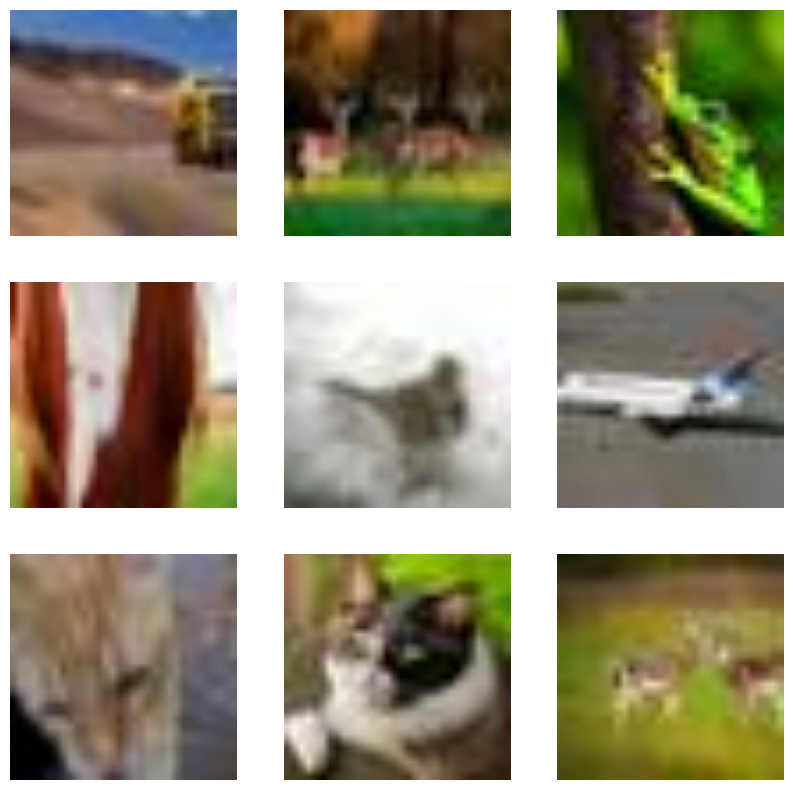

In [186]:
#plot data
images, labels = next(iter(train))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [123]:
# 0 = fake, 1 = real

In [200]:
# Model

model = keras.Sequential([
    keras.Input(shape=(96, 96, 3)),
    tf.keras.layers.Rescaling(1. / 255),
    #
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [201]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
)

In [202]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_70 (Conv2D)          (None, 94, 94, 512)       14336     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 47, 47, 512)       0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 47, 47, 512)       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 45, 45, 256)       1179904   
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 22, 22, 256)       0         
 ng2D)                                               

In [206]:
from keras.src.optimizers import RMSprop

# SGD optimizer

AUTOTUNE = tf.data.AUTOTUNE

optimizer = RMSprop(learning_rate=0.001)

train_ds = train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=AUTOTUNE)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [207]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('models/model_{epoch:02d}.h5', save_weights_only=False, save_best_only=False)


In [208]:
# Get the class names
class_names = train.class_names

# Initialize a dictionary to store the counts
class_counts = {class_name: 0 for class_name in class_names}

# Loop over the dataset and count the labels
for images, labels in train:
    for label in labels:
        class_name = class_names[np.argmax(label)]
        class_counts[class_name] += 1

# Print the counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

FAKE: 39994
REAL: 40006


In [209]:
model.fit(train, epochs=10, validation_data=val, callbacks=[checkpoint,early_stopping])

Epoch 1/10
1696/2500 [===================>..........] - ETA: 2:19 - loss: 23.1849 - accuracy: 0.5245

KeyboardInterrupt: 

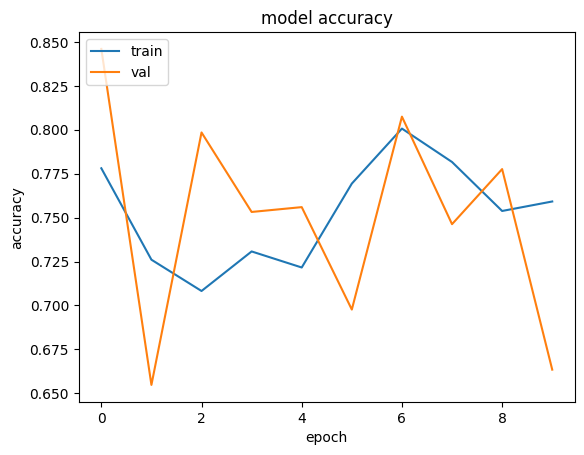

In [131]:
#plot accuracy history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [187]:
#load a real image
from keras.preprocessing import image

img = image.load_img('TestReal/img.png', target_size=(96, 96))

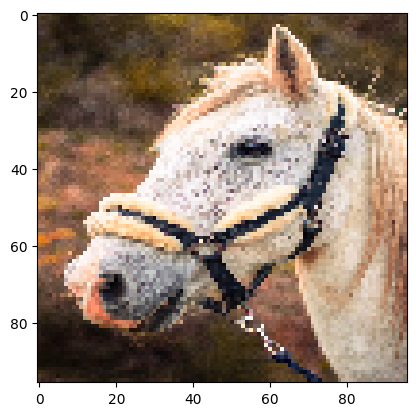

In [188]:
plt.imshow(img)

In [180]:
model_from_file = keras.models.load_model('models/model_10.h5')

In [181]:
def predict_and_return_label(img_path: str) -> tuple:
    img = image.load_img(img_path, target_size=(48, 48))
    prediction = model_from_file.predict(np.expand_dims(image.img_to_array(img), axis=0))
    if prediction[0][0] > prediction[0][1]:
        return 'fake', prediction[0][0]
    else:
        return 'real', prediction[0][1]

In [182]:
model_from_file.predict(np.expand_dims(image.img_to_array(img), axis=0))

1/1 [==============================] - 0s 300ms/step


array([[1., 0.]], dtype=float32)